# Liesel-GAM Demo Notebook

## Setup and Imports

In [1]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import numpy as np
import pandas as pd
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [2]:
def gen_tp_data(n=400, noise_sd=0.3, grid=False, seed=1):
    """
    Generate test data for tensor-product smooths.

    Parameters
    ----------
    n : int
        Number of samples (if grid=False).
    noise_sd : float
        Standard deviation of Gaussian noise.
    grid : bool
        If True, generate approximately n points on a regular grid.
        If False, generate random design points.
    seed : int
        Random seed.

    Returns
    -------
    pandas.DataFrame with columns: x, y, eta (signal), z (noisy response)
    """
    rng = np.random.default_rng(seed)

    # --- Design ----
    if grid:
        m = int(np.ceil(np.sqrt(n)))
        xs = np.linspace(0, 1, m)
        ys = np.linspace(0, 1, m)
        x, y = np.meshgrid(xs, ys, indexing="xy")
        x = x.ravel()
        y = y.ravel()
    else:
        x = rng.uniform(0, 1, n)
        y = rng.uniform(0, 1, n)

    # --- True non-separable smooth ----
    def f_true(x, y):
        return (
            1.5 * np.sin(2 * np.pi * x) * np.cos(3 * np.pi * y)
            + 0.8 * x * y
            + 2.0 * np.exp(-(((x - 0.65) ** 2) / 0.01 + ((y - 0.35) ** 2) / 0.06))
        )

    eta = f_true(x, y)
    z = eta + rng.normal(scale=noise_sd, size=len(eta))

    return pd.DataFrame({"x": x, "y": y, "eta": eta, "z": z})

In [3]:
df = gen_tp_data(n=600, noise_sd=0.25, grid=False, seed=42)
print(df.head())

          x         y       eta         z
0  0.773956  0.477506  0.935849  0.689560
1  0.438878  0.761433  0.621075  0.405865
2  0.858598  0.903328  1.334100  1.948456
3  0.697368  0.720696 -0.674870 -0.224435
4  0.094177  0.963211 -0.714339 -0.817277


In [4]:
df_grid = gen_tp_data(n=5000, grid=True)

In [5]:
df_grid

,x,y,eta,z
0,0.000000,0.0,1.162528e-19,0.103675
1,0.014286,0.0,1.344590e-01,0.380944
2,0.028571,0.0,2.678353e-01,0.366966
3,0.042857,0.0,3.990553e-01,0.008108
4,0.057143,0.0,5.270622e-01,0.798669
...,...,...,...,...
5036,0.942857,1.0,1.281348e+00,1.076909
5037,0.957143,1.0,1.164770e+00,1.171729
5038,0.971429,1.0,1.044978e+00,1.027468
5039,0.985714,1.0,9.230304e-01,0.818835


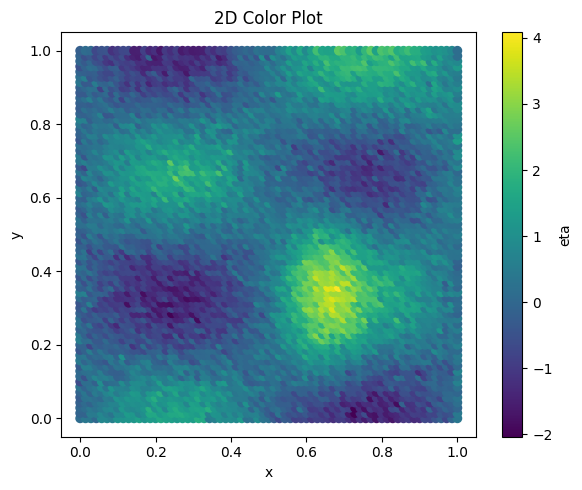

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(df_grid["x"], df_grid["y"], c=df_grid["z"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Color Plot")
plt.colorbar(label="eta")
plt.tight_layout()
plt.show()

## Model Definition

### Setup response model

In [7]:
tb = gam.TermBuilder.from_df(df)

loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


z = lsl.Var.new_obs(
    value=df.z.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="z",
)

In [8]:
loc += tb.te("x", "y", bs="ps", k=9)

### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="z_value").value


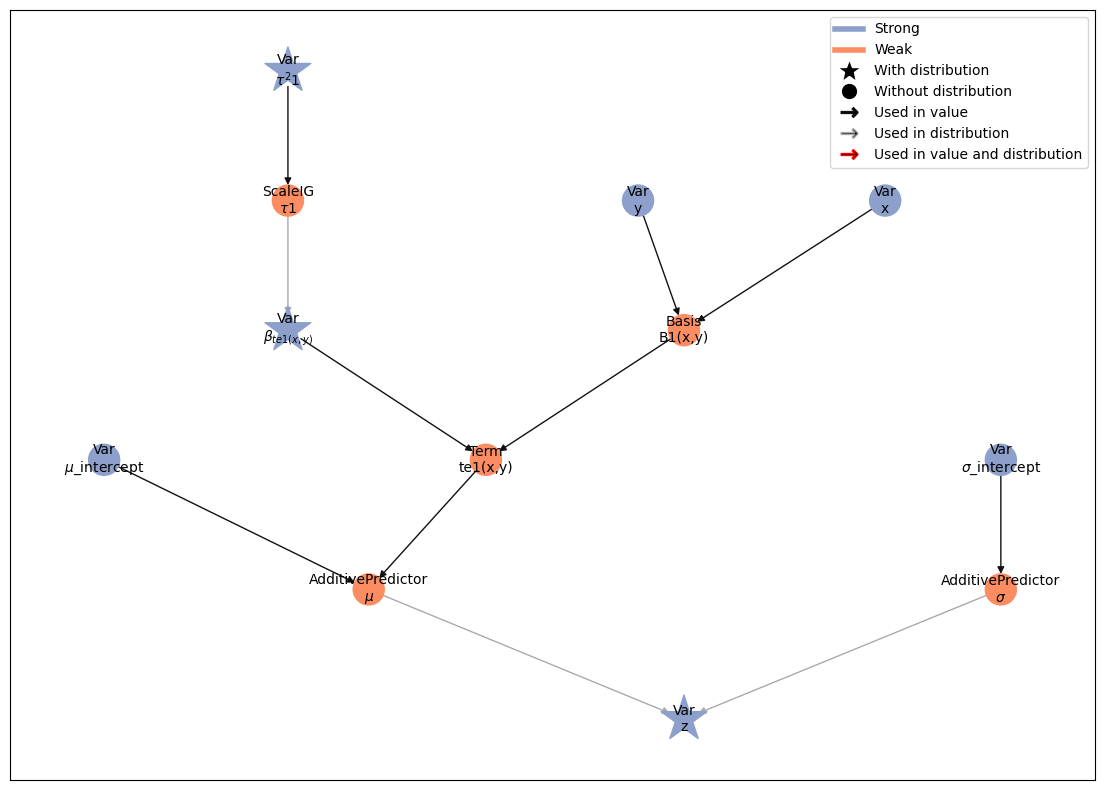

In [9]:
model = lsl.Model([z])
model.plot_vars()

## Run MCMC

In [10]:
eb = gs.LieselMCMC(model).get_engine_builder(seed=1, num_chains=4)

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=1000,
        init_duration=200,
        term_duration=200,
        thinning_posterior=5,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\sigma$_intercept', '$\\mu$_intercept', '$\\beta_{te1(x,y)}$', '$\\tau^2$1'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 200 transitions, 25 jitted together
100%|██████████████████████████████████████████| 8/8 [00:02<00:00,  3.03chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|████████████████████████████████████████| 1/1 [00:00<00:00, 1370.24chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|████████████████████████████████████████| 2/2 [00:00<00:00, 1542.02chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Start

### MCMC summary

In [11]:
summary = gs.Summary(results)
summary

Parameter summary:

                             kernel      mean        sd    q_0.05     q_0.5  \
parameter          index                                                      
$\beta_{te1(x,y)}$ (0,)   kernel_02 -0.239184  0.184372 -0.532943 -0.237204   
                   (1,)   kernel_02 -0.675888  0.166529 -0.958615 -0.676164   
                   (2,)   kernel_02 -0.526510  0.177219 -0.813637 -0.526697   
                   (3,)   kernel_02 -0.128899  0.224840 -0.502828 -0.126305   
                   (4,)   kernel_02 -0.427617  0.173871 -0.714396 -0.422626   
...                             ...       ...       ...       ...       ...   
                   (78,)  kernel_02  0.427605  0.162881  0.156042  0.430164   
                   (79,)  kernel_02  0.479612  0.411288 -0.182821  0.473836   
$\mu$_intercept    ()     kernel_01  0.361628  0.010631  0.344017  0.361381   
$\sigma$_intercept ()     kernel_00 -1.353949  0.030278 -1.403463 -1.354301   
$\tau^2$1          ()     kernel_03  1.131620  0.236993  0.794486  1.104053   

                            q_0.95  sample_size    ess_bulk    ess_tail  \
parameter          index                                                  
$\beta_{te1(x,y)}$ (0,)   0.070941          800  295.450037  531.791091   
                   (1,)  -0.391601          800  240.203556  370.606081   
                   (2,)  -0.240065          800  250.548168  507.324332   
                   (3,)   0.255938          800  258.053095  396.566420   
                   (4,)  -0.137019          800  291.414479  461.883805   
...                            ...          ...         ...         ...   
                   (78,)  0.692645          800  256.420472  440.543959   
                   (79,)  1.156740          800  258.259552  498.542697   
$\mu$_intercept    ()     0.378711          800  864.951006  771.504113   
$\sigma$_intercept ()    -1.305980          800  628.591861  795.310632   
$\tau^2$1          ()     1.575882          800  257.930388  454.269493   

                              rhat  
parameter          index            
$\beta_{te1(x,y)}$ (0,)   1.011725  
                   (1,)   1.008138  
                   (2,)   1.000870  
                   (3,)   1.005550  
                   (4,)   1.004258  
...                            ...  
                   (78,)  1.014017  
                   (79,)  1.017474  
$\mu$_intercept    ()     0.999193  
$\sigma$_intercept ()     1.003948  
$\tau^2$1          ()     1.008653  

[83 rows x 10 columns]

## Predictions

In [12]:
samples = results.get_posterior_samples()

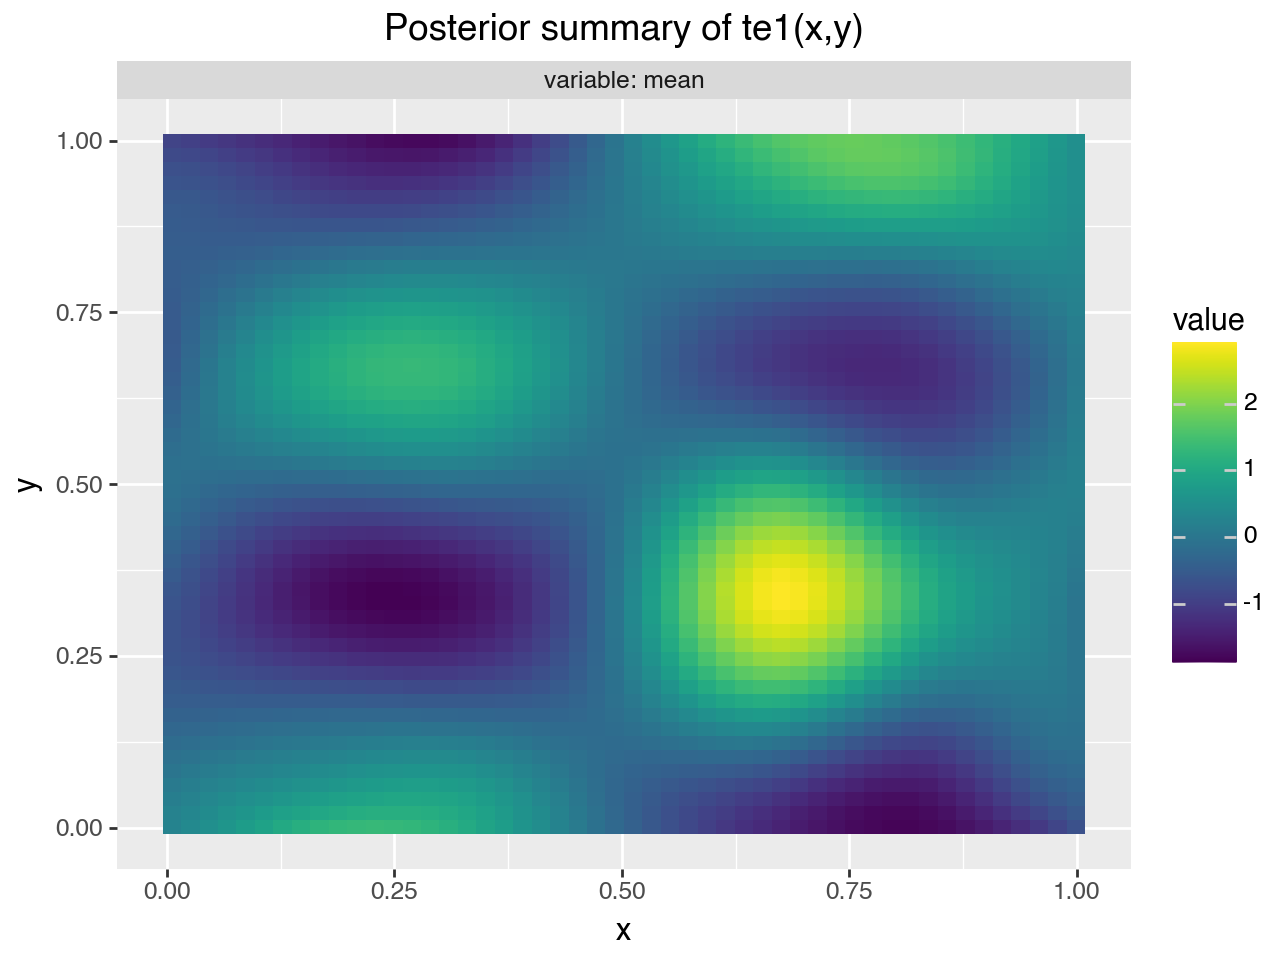

In [13]:
gam.plot_2d_smooth(
    term=loc.terms["te1(x,y)"],
    samples=samples,
    ngrid=50,
    which=["mean"],
)